<a href="https://colab.research.google.com/github/alexeybondarev/MTS_TETA_inference/blob/main/Fit_predict_team_SPAM_SMS_project__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача классификации спам сообщений в СМС, постановка задачи:
С широким проникновением мобильного интернета и мессенджеров, операторы сотовой связи начали быстро терять выручку от одного из своих самых маржинальных каналов — сервиса SMS. Все операторы достаточно быстро перестроили свою тарифную политику и теперь получают доход от данного канала не напрямую, а в рамках общей подписки на пакетный тариф (300 минут звонков и 300 SMS, к примеру). В то же время, появился и до сих пор широко распространен канал выручки для оператора от таргетированной SMS рекламы и разных сервисов, использующих SMS в качестве инструмента аутентификации пользователей или транзакций. К сожалению, в официальных финансовых отчетах не приводится какую долю выручки приносит данный канал, но если предположить, что он составляет даже 0,1%, то в денежном выражении это рынок на миллиард рублей в год.

В связи с этим для оператора важно контролировать данный канал, так чтобы он был привлекателен для корпоративных клиентов и по-прежнему востребован у пользователей. Одним из показателей качества канала для пользователя является отсутствие спама, т. е. заведомо не релевантных и раздражающих сообщений. Проблема спама общая для всех электронных каналов коммуникаций и давно известная. Для канала SMS она характеризуется тем, что обработка спама может и должна проходить на стороне оператора.

В связи с этим бизнес задача может быть сформулирована следующих образом:

* Создать сервис автоматической блокировки SMS спама на стороне оператора, к которому принадлежит абонент.
* Обеспечить работу в связке с SMS шлюзом. Он не должен вносить существенных временных задержек (это может быть критично для финансовых транзакций), а также не требовать большого количества оборудования
* Обеспечить высокое качество сервиса по метрикам Accuracy (> 90%), Precision (> 90%) и Recall (> 90%). При этом необходимо обратить внимание на ошибки первого рода (< 10% от общего количества классифицированных сообщений).

С учетом объема рынка, который можно очень грубо оценить в миллиард рублей, при 4-х операторах связи в России, наличие такого сервиса у оператора может быть высоким конкурентным преимуществом. Дополнительные 10% рынка, полученные у конкурентов, это дополнительные 100 млн рублей годовой выручки.

Критерием успеха будем считать увеличение объема выручки на 0.1%.

# Постановка задачи машинного обучения:
Таким образом, была поставлена задача классификации текстовых SMS сообщений на два класса спам/не спам.

Пайплайн разработки и внедрения модели машинного обучения для определения SMS-спама состоит из следующих шагов:
- выбор и тренировка части модели, превращающей текст SMS в векторное латентное представление. В качестве данной части могут быть применены как такие подходы  как Bag of words, TF-IDF, так и нейросетевые подходы, в том числе трансформеры
- выбор, тренировка, подбор гиперпараметров для второй части модели — бинарного классификатора над латентным представлением текста. В качестве этих моделей могут быть использованы классические подходы (логистическая регрессия, случайный лес), байесовские подходы или нейросетевые классификаторы.

Выбор обоих частей можно вести независимо, в качестве критерия стоит обращать внимание на качество модели (метрики accuracy, precision, recall), скорость и сложность обучения модели, скорость и сложность инференса в продуктовой среде

Ремарка. В качестве тестового датасета был выбран свободно доступный датасет SMS сообщений на английском языке https://www.kaggle.com/uciml/sms-spam-collection-dataset. Это достаточно хороший датасет из 5574 сообщений, собранных из реальных источников. Однако, реальную модель для использования требуется тренировать на языке страны, в которой эта модель будет внедрена, в нашем случае на русском. Мы исходим из гипотезы, что различия в качестве между разными моделями для русского и английского языков, а также различия в применяемых подходах/библиотеках будут незначительными, однако, это требует дополнительной проверки. 

# Получение данных и предобработка

In [ ]:
import numpy as np 
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings('ignore')
import re
import torch
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

In [ ]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# Удаляем лишние столбцы
sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
sms.rename(columns={"v1":"label", "v2":"text"}, inplace=True)
sms.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
sms['label'].replace({'ham':0,'spam':1},inplace=True)
sms.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
stop = stopwords.words('english')

In [ ]:
sms['n_of_stopwords'] = sms['text'].agg(lambda x: len([w for w in x.split() if w in stop]))
sms.head()

,label,text,n_of_stopwords
0,0,"Go until jurong point, crazy.. Available only ...",4
1,0,Ok lar... Joking wif u oni...,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,5
3,0,U dun say so early hor... U c already then say...,2
4,0,"Nah I don't think he goes to usf, he lives aro...",5


In [ ]:
# Удаляем знаки препинания
sms['n_of_signs'] = sms['text'].agg(lambda x: len(re.findall('[^\w\s]', x)))
sms['text'] = sms['text'].agg(lambda x: re.sub('[^\w\s]', '', x))
sms.head(2)

,label,text,n_of_stopwords,n_of_signs
0,0,Go until jurong point crazy Available only in ...,4,9
1,0,Ok lar Joking wif u oni,0,6


In [ ]:
stemmer = SnowballStemmer('english')
def stemming(text):
    text = ' '.join(stemmer.stem(word) for word in text.split())
    return text

In [ ]:
sms['text'] = sms['text'].apply(stemming)
sms.head()

,label,text,n_of_stopwords,n_of_signs
0,0,go until jurong point crazi avail onli in bugi...,4,9
1,0,ok lar joke wif u oni,0,6
2,1,free entri in 2 a wkli comp to win fa cup fina...,5,6
3,0,u dun say so earli hor u c alreadi then say,2,6
4,0,nah i dont think he goe to usf he live around ...,5,2


# Визуализация данных

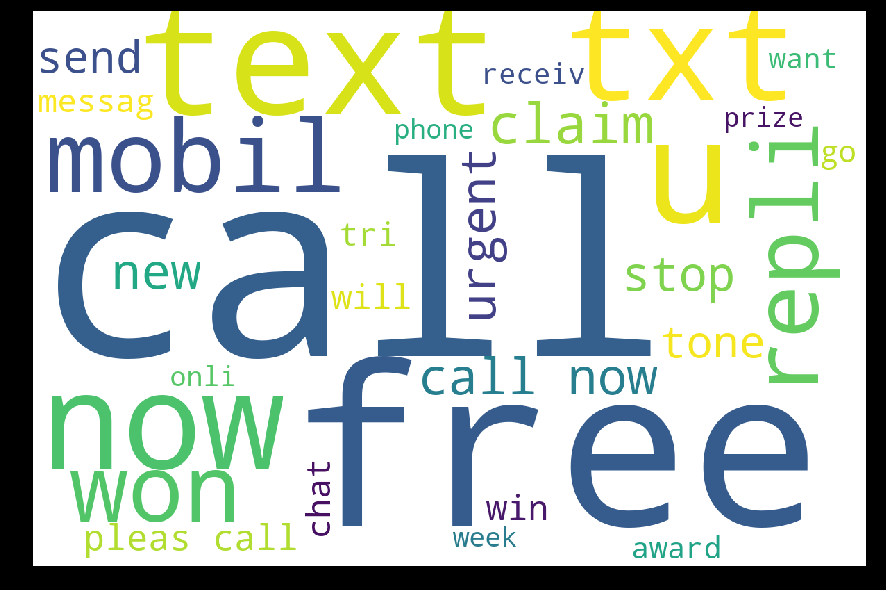

In [ ]:
# Создаем WordCloud с наиболее часто встречающимися словами в спам смс
from wordcloud import WordCloud

spams=sms['text'][sms['label']==1]

spamcloud = WordCloud(width=1200,height=800,background_color='white',max_words=30).generate(' '.join(spams))

plt.figure(figsize=(12,8),facecolor='k')
plt.imshow(spamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

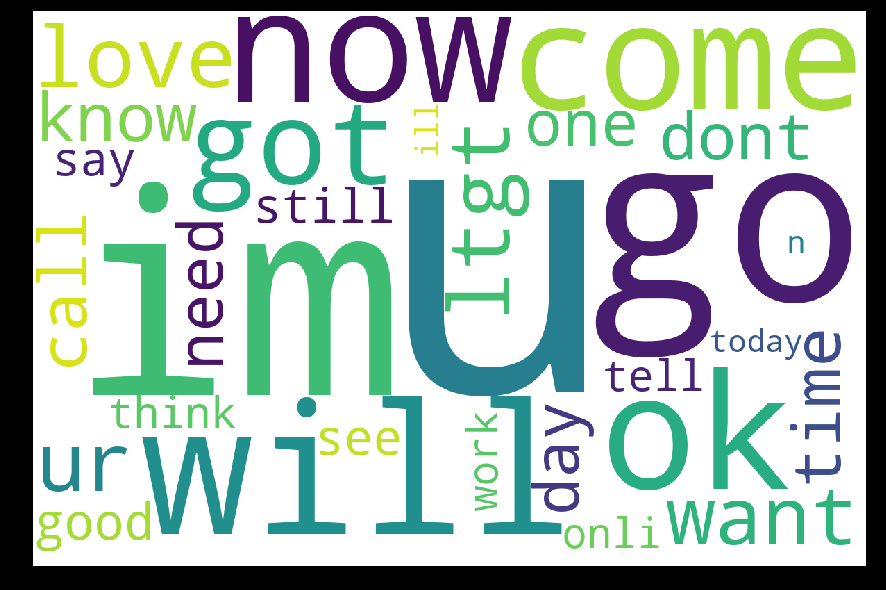

In [ ]:
# Создаем WordCloud с наиболее часто встречающимися словами в обычныз смс
from wordcloud import WordCloud

spams=sms['text'][sms['label']==0]

notspamcloud = WordCloud(width=1200,height=800,background_color='white',max_words=30).generate(' '.join(spams))

plt.figure(figsize=(12,8),facecolor='k')
plt.imshow(notspamcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Использование готовой модели из библиотеки Huggingface
В данной задаче исходными данными являются тексты, в связи с этим естественной гипотезой является использование SOTA подходов для работы с текстами, построенными на архитектуре трансформеров. Ожидается, что данные модели должны показать лучшее качество. В качестве первого эксперимента воспользуемся готовой моделью из библиотеки Huggingface - https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection Данная модель построена поверх Bern-tiny и натренирована на задаче детекции спам в СМС сообщениях

In [ ]:
! pip install datasets transformers[sentencepiece]

  Using cached https://files.pythonhosted.org/packages/9f/40/5d3df41be03e6947d7faaafe27bd9e4b94d3730b94e3189b679f11f9f390/datasets-1.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/82/45cdbb3fb7b76df31c09488548026ab001310dafa9ab796157ecf47715fa/pyarrow-5.0.0-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/fa/2f/efa2492dda74720eef27bf1f2f210a2aa456d5d167cf5bcfee593ea54091/sentencepiece-0.1.91-cp36-cp36m-win_amd64.whl
  Found existing installation: pyarrow 0.11.1
    Uninstalling pyarrow-0.11.1:


C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_internal\req\req_install.py:391: UserWarning: Unbuilt egg for Unknown [unknown version] (c:\programdata\watsonstudiodesktop\miniconda3\envs\desktop\lib\site-packages)
  self.satisfied_by = pkg_resources.get_distribution(str(no_marker))
Error checking for conflicts.
Traceback (most recent call last):
  File "C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2897, in _dep_map
    return self.__dep_map
  File "C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_vendor\pkg_resource

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification 

tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")

In [ ]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [ ]:
num_batches = 10
raw_inputs = sms.text.to_list()
labels = sms.label.to_list()

batch_size = len(raw_inputs) // num_batches
print('batch size = ', batch_size)

total_predictions = []

for i in range(num_batches):
  batch = raw_inputs[i*batch_size: (i+1)*batch_size]
  inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt") 
  outputs = model(**inputs)
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  total_predictions.extend(np.argmax(predictions.detach().numpy(), axis = 1))

batch = raw_inputs[10*batch_size: len(raw_inputs)]
inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt") 
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
total_predictions.extend(np.argmax(predictions.detach().numpy(), axis = 1))

print(len(total_predictions))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


batch size =  557
5572


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

In [ ]:
from sklearn.metrics import confusion_matrix
categories=['Ham', 'Spam']
def seaborn_conf(y, ypred):
    y_true = ["Ham", "Spam"]
    y_pred = ["Ham", "Spam"]
    cf = confusion_matrix(y, ypred)
    df_cm = pd.DataFrame(cf, columns=np.unique(y_true), index = np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted value')
    plt.ylabel('Real value')
    plt.show()

Accuracy: 0.9754127781765972


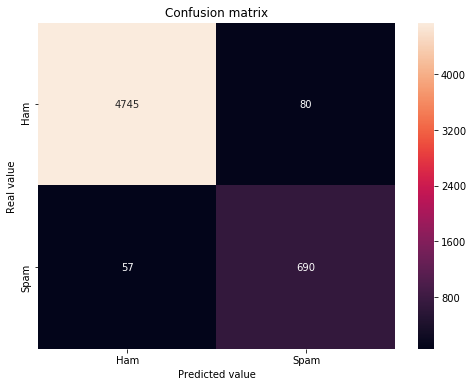

In [ ]:
print('Accuracy: {}'.format(accuracy_score(labels, total_predictions)))
seaborn_conf(labels, total_predictions)

In [ ]:
print(classification_report(labels, total_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9881    0.9834    0.9858      4825
           1     0.8961    0.9237    0.9097       747

   micro avg     0.9754    0.9754    0.9754      5572
   macro avg     0.9421    0.9536    0.9477      5572
weighted avg     0.9758    0.9754    0.9756      5572



# Построение собственной модели классификации с использованием Bert из Huggingface
Учитывая успешные результаты первого эксперимента, следующая задача - показать, что аналогичную модель можно построить, используя только предобученную модель общего плана (Bert-like) с самостоятельной головой классификации.

In [ ]:
!pip install transformers

Error checking for conflicts.
Traceback (most recent call last):
  File "C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2897, in _dep_map
    return self.__dep_map
  File "C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2888, in _parsed_pkg_info
    return self._pkg_info
  File "C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above excepti

In [ ]:
import transformers
import string

In [ ]:
# Loading pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def clean_sentence(s):
    """Given a sentence remove its punctuation and stop words"""
    
    stop_words = set(stopwords.words('english'))
    s = s.translate(str.maketrans('','',string.punctuation)) # remove punctuation
    tokens = word_tokenize(s)
    cleaned_s = [w for w in tokens if w not in stop_words] # removing stop-words
    return " ".join(cleaned_s[:20]) # using the first 10 tokens only

sms["text"] = sms["text"].apply(clean_sentence)

In [ ]:
tokenized = sms["text"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized

0       [101, 2175, 18414, 17583, 2391, 13675, 16103, ...
1       [101, 7929, 2474, 2099, 8257, 15536, 2546, 105...
2       [101, 2489, 4372, 18886, 1016, 1059, 2243, 366...
3       [101, 1057, 24654, 2360, 4656, 2072, 7570, 209...
4       [101, 20976, 2123, 2102, 2228, 2175, 2063, 214...
                              ...                        
5567    [101, 3416, 2051, 13012, 1016, 3967, 1057, 105...
5568    [101, 1195, 29763, 1038, 2175, 9686, 24759, 51...
5569       [101, 6770, 2072, 6888, 2061, 7088, 6592, 102]
5570    [101, 3124, 7743, 2552, 2066, 8909, 3037, 4965...
5571                 [101, 20996, 10258, 2995, 2171, 102]
Name: text, Length: 5572, dtype: object

In [ ]:
max_len = tokenized.apply(len).max() # get the length of the longest tokenized sentence

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) # padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence
padded

array([[  101,  2175, 18414, ...,     0,     0,     0],
       [  101,  7929,  2474, ...,     0,     0,     0],
       [  101,  2489,  4372, ...,     0,     0,     0],
       ...,
       [  101,  6770,  2072, ...,     0,     0,     0],
       [  101,  3124,  7743, ...,     0,     0,     0],
       [  101, 20996, 10258, ...,     0,     0,     0]])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
input_ids = torch.tensor(padded)  # create a torch tensor for the padded sentences
input_ids = torch.tensor(padded).to(torch.int64)
attention_mask = torch.tensor(attention_mask) # create a torch tensor for the attention matrix



with torch.no_grad():
    encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

In [ ]:
X = encoder_hidden_state[0][:,0,:].numpy()

In [ ]:
sms["num_words"] = sms["text"].apply(lambda s: len(re.findall(r'\w+', s))) # Count the number of words in the message
sms["message_len"] = sms["text"].apply(len) # get the length of the text message

In [ ]:
sms.head(2)

,label,text,n_of_stopwords,n_of_signs,num_words,message_len
0,0,go jurong point crazi avail onli bugi n great ...,4,9,17,81
1,0,ok lar joke wif u oni,0,6,6,21


In [ ]:
X = encoder_hidden_state[0][:,0,:].numpy()
X = np.hstack((X, sms[["num_words", "message_len"]].to_numpy().reshape(-1, 2))) # addind the the engineered features from the beginning
y = sms["label"].astype('int')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
y_train.value_counts()

0    3619
1     560
Name: label, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=1500, class_weight="balanced", n_jobs=-1, random_state=42) # Create a baseline random forest (no cross-validation, no hyperparameter tuning)
model=RandomForestClassifier()
model.fit(X_train,y_train)
pred=model.predict(X_test)

Accuracy score 0.9676956209619526


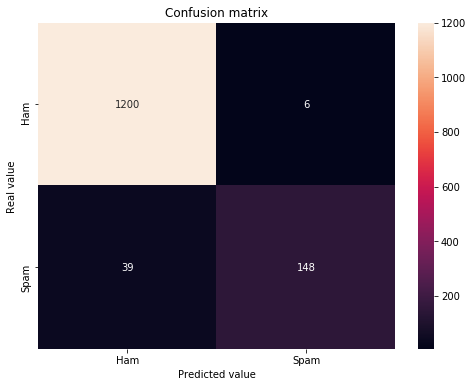

-----------------------------------------
Confusion Matrix
[[1200    6]
 [  39  148]]
-----------------------------------------
Classification Report
              precision    recall  f1-score   support

           0     0.9685    0.9950    0.9816      1206
           1     0.9610    0.7914    0.8680       187

   micro avg     0.9677    0.9677    0.9677      1393
   macro avg     0.9648    0.8932    0.9248      1393
weighted avg     0.9675    0.9677    0.9664      1393



In [ ]:
print('Accuracy score', accuracy_score(y_test, pred))
seaborn_conf(y_test, pred)
print('-----------------------------------------')
print('Confusion Matrix')
print(confusion_matrix(y_test, pred))
print('-----------------------------------------')
print('Classification Report')
print(classification_report(y_test, pred, digits=4))

Выводы:

* Доказано, что качество по метрике accuracy можно получить 97%
* Значительно ниже получилась метрика recall для спам сообщений, однако в данном эксперименте не проводился подбор классификатора и его гиперпарметров. Скорее всего данную все метрики можно улучшить подбором классификатора и гиперпараметров
* Обучение модели для получения латентного представления - главное бутылочное горлышко данного подхода. Во-первых, обучение на данном небольшом датасете заняло достаточно длительное время (несколько минут), к тому же пришлось ограничить размер СМС в 20 слов, чтобы обойти ограничение по памяти

# Полиномиальный вариант наивного байесовского классификатора
Теперь применим вероятностный классификатор на основе теоремы Байеса. Данный вариант будет отличаться тем, что задействует меньше вычислительных ресурсов, следовательно займет меньшее количество времени. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features= 2500)

In [ ]:
X = cv.fit_transform(sms.text).toarray()
X = pd.DataFrame(np.hstack([sms.iloc[:, -4:], X]))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503
0,4,9,17,81,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,6,6,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,6,20,101,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,6,9,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2,8,41,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = pd.get_dummies(sms.label, drop_first=True)
y = np.array(y)
print(y.shape)

(5572, 1)


In [ ]:
from sklearn.naive_bayes import  MultinomialNB
from sklearn.metrics import accuracy_score,precision_score, recall_score, classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [ ]:
multi_clf = MultinomialNB()
multi_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
sms.groupby('label').agg(['mean', 'std'])

n_of_stopwords           n_of_signs            num_words            \
                mean       std       mean       std       mean       std   
label                                                                      
0           4.451813  4.765240   3.982591  4.775137   7.963938  5.205912   
1           5.361446  2.948715   6.157965  3.527631  16.313253  4.032492   

      message_len             
             mean        std  
label                         
0       40.789223  27.889948  
1       98.674699  23.166143

Accuracy score 0.9838565022421525


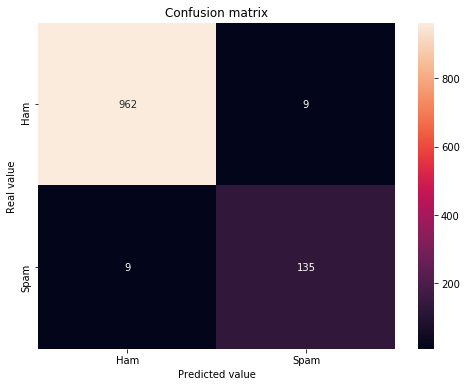

-----------------------------------------
Confusion Matrix
[[962   9]
 [  9 135]]
-----------------------------------------
Classification Report
              precision    recall  f1-score   support

           0     0.9907    0.9907    0.9907       971
           1     0.9375    0.9375    0.9375       144

   micro avg     0.9839    0.9839    0.9839      1115
   macro avg     0.9641    0.9641    0.9641      1115
weighted avg     0.9839    0.9839    0.9839      1115



In [ ]:
print('Accuracy score', accuracy_score(y_test, multi_clf.predict(X_test)))
seaborn_conf(y_test, multi_clf.predict(X_test))
print('-----------------------------------------')
print('Confusion Matrix')
print(confusion_matrix(y_test, multi_clf.predict(X_test)))
print('-----------------------------------------')
print('Classification Report')
print(classification_report(y_test, multi_clf.predict(X_test), digits=4))

# Выводы:
* Модель байесовского классификатора по метрике accuracy сопоставима с первым вариантом, разница в показателе незначительная, и может нивелироваться подбором гиперпараметров.
* По метрикам precision и recall результаты также сопоставимы с первым классификатором, чуть хуже recall для спам сообщений, зато для них лучше показатель precision, что говорит о том, что мы стали реже допускать ошибку, когда обычные смс классифицируются как спам, но чаще, когда спам классифицируются как обычные смс.
* Поскольку данный метод классификации отрабатывает также хорошо как первый, но зато занимает значительно меньше времени, меньше вычислительных ресурсов, он рекомендуется как основной для применения модели в продуктовой среде. 

# XGBoost
По вышеописанным причинам, было решено откинуть модель из библиотеки Huggingface, и попробовать взять XGBoost. Данная модель реализует алгоритм градиентного бустинга на решающих деревьях.

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
state = 12  
test_size = 0.30  
  
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  
    test_size=test_size, random_state=state)

In [ ]:
modelXGB = XGBClassifier()
modelXGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
predictions = modelXGB.predict(X_val)

Accuracy score 0.968609865470852


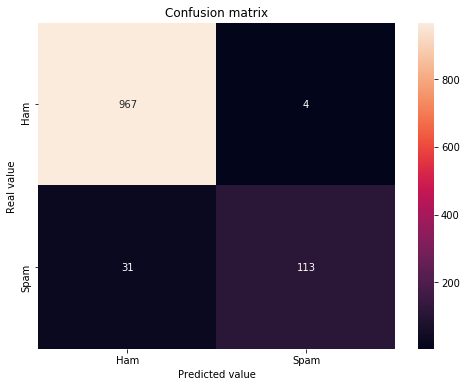

-----------------------------------------
Confusion Matrix
[[967   4]
 [ 31 113]]
-----------------------------------------
Classification Report
              precision    recall  f1-score   support

           0     0.9689    0.9959    0.9822       971
           1     0.9658    0.7847    0.8659       144

   micro avg     0.9686    0.9686    0.9686      1115
   macro avg     0.9674    0.8903    0.9241      1115
weighted avg     0.9685    0.9686    0.9672      1115



In [ ]:
print('Accuracy score', accuracy_score(y_test, modelXGB.predict(X_test)))
seaborn_conf(y_test, modelXGB.predict(X_test))
print('-----------------------------------------')
print('Confusion Matrix')
print(confusion_matrix(y_test, modelXGB.predict(X_test)))
print('-----------------------------------------')
print('Classification Report')
print(classification_report(y_test, modelXGB.predict(X_test), digits=4))

Данная модель сопоставима по результатам метрик с нашей базовой моделью. За исключением того, что Precision по классу 1 стало заметно лучше, но Recall метрика стала меньше. Это означает, что наша модель сдала лучше выявлять спам сообщения, но в связи с этим, чаще обычные сообщения классифицируются как спам.

# Валидация моделей

Провалидируем нашу базовую модель построенную на наивном байесовском классификаторе и моделель XGBoost.
Чтобы выбрать вариант классификации, посмотрим на соотношение классов.

In [ ]:
sms.groupby('label').count()

,text,n_of_stopwords,n_of_signs,num_words,message_len
label,,,,,
0,4825,4825,4825,4825,4825
1,747,747,747,747,747


Как мы можем наблюдать, в наших данных большой дисбаланс классов, по этой причине наилучшим способом валидации будет являться StratifiedKFold. Данныый метод является вариацией KFold разбиения, но возвращает стратифицированные фолды, то есть каждая выборка будет содержать примерно такой же процент разбиения классов, что и наши полные данные.

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from statistics import mean
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
X = X.to_numpy()

In [ ]:
split = 7
skf = StratifiedKFold(split)

p_score_multi_clf=[]
r_score_multi_clf=[]

for train, test in skf.split(X, y):
    multi_clf = MultinomialNB()
    X_train = X[train]
    X_test = X[test]
    y_train, y_test = y[train], y[test]
    multi_clf.fit(X_train, y_train)
    p_score_multi_clf.append(precision_score(y_test, multi_clf.predict(X_test)))
    r_score_multi_clf.append(recall_score(y_test, multi_clf.predict(X_test)))

In [ ]:
for i in range(split):
    print('Fold # ', i+1)
    print('precision score = ', p_score_multi_clf[i]) 
    print('recall score = ', r_score_multi_clf[i]) 

print('\naverage precision score =',mean(p_score_multi_clf))
print('average recall score =',mean(r_score_multi_clf))

Fold #  1
precision score =  0.9107142857142857
recall score =  0.9532710280373832
Fold #  2
precision score =  0.9158878504672897
recall score =  0.9158878504672897
Fold #  3
precision score =  0.9339622641509434
recall score =  0.9252336448598131
Fold #  4
precision score =  0.97
recall score =  0.9065420560747663
Fold #  5
precision score =  0.9245283018867925
recall score =  0.9158878504672897
Fold #  6
precision score =  0.9074074074074074
recall score =  0.9245283018867925
Fold #  7
precision score =  0.8938053097345132
recall score =  0.9528301886792453

average precision score = 0.9223293456230331
average recall score = 0.9277401314960828


In [ ]:
skf = StratifiedKFold(split)

p_score_xgb_clf=[]
r_score_xgb_clf=[]

for train, test in skf.split(X, y):
    modelXGB = XGBClassifier()
    X_train = X[train]
    X_test = X[test]
    y_train, y_test = y[train], y[test]
    modelXGB.fit(X_train, y_train)
    p_score_xgb_clf.append(precision_score(y_test, modelXGB.predict(X_test)))
    r_score_xgb_clf.append(recall_score(y_test, modelXGB.predict(X_test)))

In [ ]:
for i in range(split):
    print('Fold # ', i+1)
    print('precision score = ', p_score_xgb_clf[i]) 
    print('recall score = ', r_score_xgb_clf[i]) 

print('\naverage precision score =',mean(p_score_xgb_clf))
print('average recall score =',mean(r_score_xgb_clf))

Fold #  1
precision score =  0.9484536082474226
recall score =  0.8598130841121495
Fold #  2
precision score =  0.967032967032967
recall score =  0.822429906542056
Fold #  3
precision score =  0.989010989010989
recall score =  0.8411214953271028
Fold #  4
precision score =  0.978021978021978
recall score =  0.8317757009345794
Fold #  5
precision score =  0.9310344827586207
recall score =  0.7570093457943925
Fold #  6
precision score =  0.9753086419753086
recall score =  0.7452830188679245
Fold #  7
precision score =  0.967391304347826
recall score =  0.839622641509434

average precision score = 0.9651791387707302
average recall score = 0.8138650275839484


# Вывод
* Обе модели достаточно стабильны по фолдам (отклонение каждого показателя с средним значением не критическое). Из чего мы можем сделать вывод, что  разбиение StratifiedKFold было правильным решением.
* Прироста качества второй модели по отношению к базовой, не наблюдается. Можно только заметить смещение метрик, что говорит о том, что мы просто стали больше классифицировать не спам сообщения как спам.
* По скольку, для нашей бизнесс-задачи, все же важнее, чтобы мы не отмечали обычные смс как спам, так как это может привести к большему недовольству пользователей, решено было остановиться на базовой моделе, то есть на наивном байесовском классификаторе.